<h1 id="Kaggle-Digit-Recognizer ">Kaggle Digit Recognizer&nbsp;</h1>

<h2 id="MNIST-Image-Classification with-Keras-CNN-model">MNIST Image Classification&nbsp;with Keras CNN model</h2>

<p>conditions:</p>

<ol>
	<li>Image input from local data, normalized and reshape input to [-1, HEIGHT, WIDTH, 1]</li>
	<li>data&nbsp;augmentation</li>
	<li>CNN model, ir = 0.001 with decrease schedule</li>
	<li>train for 20 &nbsp;- 30 epochs</li>
	<li>ensemble learning</li>
</ol>

<p>&nbsp;</p>

<p>&nbsp;</p>


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os
import json

from sklearn.model_selection import train_test_split


import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

1.13.1


<h2 id="Exploring-and-processing data">Exploring and processing&nbsp;data</h2>


In [15]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [16]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
train.label.count()

42000

In [18]:
train_images = train.drop(labels = ["label"],axis = 1)
train_labels = train["label"]


In [19]:
train_images = train_images.to_numpy()/255.0
test_images = test.to_numpy()/255.0


In [20]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

In [21]:
train_labels.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

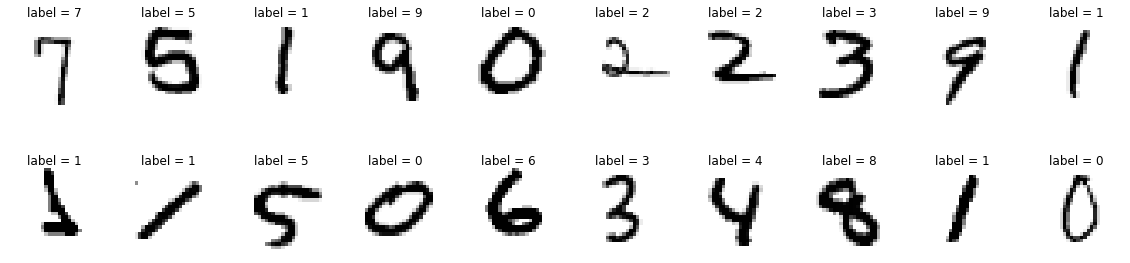

In [22]:
i = 50
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(train_images[IMGNO].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.title("label = %d" % train_labels[IMGNO],y=0.9)
    plt.axis('off')

In [14]:
train_images = train_images.reshape(-1,HEIGHT,WIDTH,1)
test_images = test_images.reshape(-1,HEIGHT,WIDTH,1)

train_labels = keras.utils.to_categorical(train_labels, num_classes = NCLASSES)

In [10]:
train_labels[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.1)

len(Y_train)

37800

## Data augmentation

In [13]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

datagen.fit(X_train)

## CNN model with Keras functional API


In [14]:
def get_model():

    X = keras.layers.Input(shape = (HEIGHT, WIDTH, 1))

    c1 = keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu')(X)   # shape = (batch_size, HEIGHT, WIDTH, nfil1)

    #c1 = keras.layers.BatchNormalization()(c1)          
                      
    p1 = keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c1)                                                       # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil1)
    
    c2 = keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu')(p1)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)
    
    #c2 = keras.layers.BatchNormalization()(c2)   

    p2 = keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c2)                                                        # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

    c3 = keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(p2)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)

    #c3 = keras.layers.BatchNormalization()(c3)      

    p3 = keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c3)                                                      # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

    p3 = keras.layers.Flatten()(p3)                                                                               # shape = (batch_size, HEIGHT // 4 * WIDTH // 4 * nfil2)

    h3 = keras.layers.Dense(units = 64, activation = 'relu')(p3)
    
    #h3 = keras.layers.BatchNormalization()(h3)               
    
    h3 = keras.layers.Dropout(rate = 0.25)(h3)

    output = keras.layers.Dense(units = NCLASSES, activation = 'softmax')(h3)
  
    #output = keras.layers.BatchNormalization()(output)

    model = keras.Model(inputs=X, outputs=output)
    
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [15]:
print(get_model().summary())

#keras.utils.plot_model(model, to_file='digit-cnn-keras_graph.png')

#display(Image.open('digit-cnn-keras_graph.png'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)    

<h2 id="train-model">Train 10 models</h2>


In [16]:
# with augmentation

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

batch_size = 100
epochs = 30

# run the same models ${ens} times
ens = 10

history = [0] * ens
model = [0]*ens

for en in range(len(model)):
    model[en] = get_model()
    X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.1)
    
    history[en] = model[en].fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,Y_val),
                              verbose = 0, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[annealer])
    
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        en+1,epochs,max(history[en].history['acc']),max(history[en].history['val_acc']) ))

Instructions for updating:
Use tf.cast instead.
4200/4200 [==============================] - 2s 562us/sample - loss: 0.0260 - acc: 0.9924
CNN 1: Epochs=30, Train accuracy=0.99286, Validation accuracy=0.99429
4200/4200 [==============================] - 2s 591us/sample - loss: 0.0338 - acc: 0.9924
CNN 2: Epochs=30, Train accuracy=0.99241, Validation accuracy=0.99310
4200/4200 [==============================] - 2s 562us/sample - loss: 0.0229 - acc: 0.9945
CNN 3: Epochs=30, Train accuracy=0.99220, Validation accuracy=0.99452
4200/4200 [==============================] - 2s 572us/sample - loss: 0.0278 - acc: 0.9933
CNN 4: Epochs=30, Train accuracy=0.99214, Validation accuracy=0.99357
4200/4200 [==============================] - 2s 558us/sample - loss: 0.0393 - acc: 0.9919
CNN 5: Epochs=30, Train accuracy=0.99368, Validation accuracy=0.99190
4200/4200 [==============================] - 2s 563us/sample - loss: 0.0314 - acc: 0.9902


4200/4200 [==============================] - 2s 562us/sample - loss: 0.0305 - acc: 0.9910
CNN 6: Epochs=30, Train accuracy=0.99206, Validation accuracy=0.99214
4200/4200 [==============================] - 2s 565us/sample - loss: 0.0237 - acc: 0.9943
CNN 7: Epochs=30, Train accuracy=0.99320, Validation accuracy=0.99500
4200/4200 [==============================] - 2s 562us/sample - loss: 0.0214 - acc: 0.9945
CNN 8: Epochs=30, Train accuracy=0.99140, Validation accuracy=0.99452
4200/4200 [==============================] - 2s 568us/sample - loss: 0.0234 - acc: 0.9943
CNN 9: Epochs=30, Train accuracy=0.99130, Validation accuracy=0.99476
4200/4200 [==============================] - 3s 670us/sample - loss: 0.0184 - acc: 0.9933
CNN 10: Epochs=30, Train accuracy=0.99209, Validation accuracy=0.99476


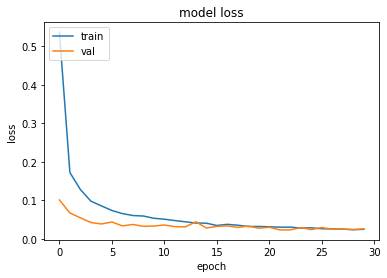

loss: 0.0260   


In [17]:
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("loss: {0:.4f}   ".format(history[0].history['val_loss'][-1]))

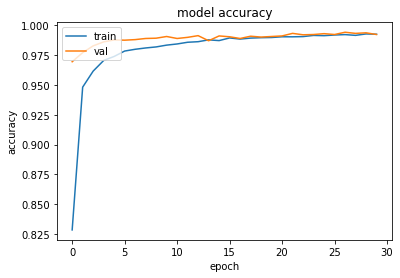

Acc: 0.9924  


In [18]:
plt.plot(history[0].history['acc'])
plt.plot(history[0].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("Acc: {0:.4f}  ".format(history[0].history['val_acc'][-1],))

## Prediction

In [19]:
# ensemble predictions
pred = np.zeros( (test_images.shape[0],NCLASSES) ) 
for en in range(ens):
    pred = pred + model[en].predict(test_images,batch_size=2000,verbose=1)
pred = np.argmax(pred,axis = 1)

28000/28000 [==============================] - 15s 528us/sample


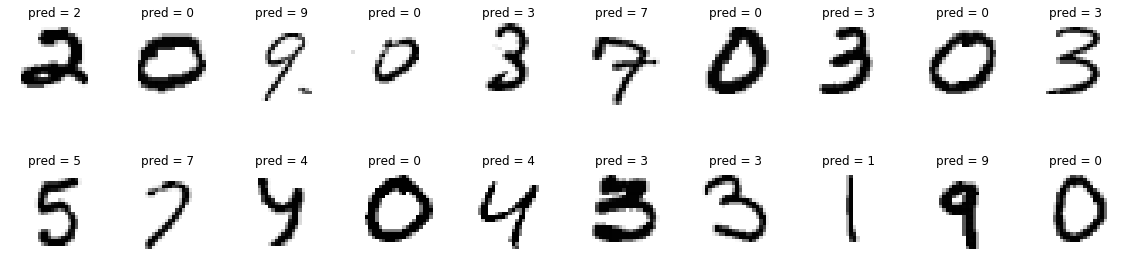

In [20]:
i=0
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(test_images[IMGNO].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("pred = %d" % pred[IMGNO],y=0.9)
    plt.axis('off')
#plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [21]:
pred[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3], dtype=int64)

## Output

In [22]:
output = pd.DataFrame({ 'ImageId' : np.arange(len(pred))+1, 'Label': pred })
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [23]:
output.to_csv('data/sub_digit_v02_ens10_30ep.csv', index = False)


In [25]:
# save models

for en in range(len(model)):
    model[en].save('data/model_digit_v02_ens10_30ep_' + '{:02d}'.format(en) + '.h5')
    
# load model example: model = keras.models.load_model('model.h5')    

In [70]:
#save history

history_dict =[0]*ens

for en in range(ens):
    history_dict[en] = history[en].history
    
pd.Series(history_dict).to_json('data/history_digit_v02_ens10_30ep.json')
#load back history history_dict_in=pd.read_json('data/history_digit_v02_ens10_30ep.json')

<h2 id="Summary">Summary</h2>

<p>single model</p>

<table align="left" border="2" cellpadding="1" cellspacing="1" style="width: 500px">
	<thead>
		<tr>
			<th scope="col">kaggle score</th>
			<th scope="col">rank</th>
			<th scope="col">data augmentation</th>
			<th scope="col">batch norm</th>
			<th scope="col">epochs</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>0.99057</td>
			<td>&nbsp;</td>
			<td>No</td>
			<td>No</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99185</td>
			<td>1017</td>
			<td>No</td>
			<td>Yes</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99257</td>
			<td>910</td>
			<td>Yes</td>
			<td>No</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99457</td>
			<td>655</td>
			<td>Yes</td>
			<td>No</td>
			<td>30</td>
		</tr>
	</tbody>
</table>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>ensemble model predictions</p>

<table align="left" border="2" cellpadding="1" cellspacing="1" style="width: 500px">
	<thead>
		<tr>
			<th scope="col">kaggle score</th>
			<th scope="col">rank</th>
			<th scope="col"># of models</th>
			<th scope="col">epochs</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>0.99457</td>
			<td>655</td>
			<td>1</td>
			<td>30</td>
		</tr>
		<tr>
			<td>0.99185</td>
			<td>&nbsp;</td>
			<td>5</td>
			<td>5</td>
		</tr>
		<tr>
			<td>0.99628</td>
			<td>330</td>
			<td>10</td>
			<td>30</td>
		</tr>
	</tbody>
</table>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<p>ensemble learning method&nbsp;significantly improves the acc</p>

<p>&nbsp;</p>


<h2 id="Next-step-to-improve-acc">Next step&nbsp;</h2>

<ul>
	<li>add confusion matrix</li>
</ul>

<p>&nbsp;</p>

<h2 id="Credits">Credits</h2>

<p><a href="https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist" target="_blank">https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist</a></p>

<p><a href="https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras" target="_blank">https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras</a></p>
